In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
import tensorflow as tf
import pandas as pd
import numpy as np


# 1 - Import and refactoring 

In [14]:
# Import : data 1 row = 1 value - ESSAI 1 : données toutes NCS DAD
# df = pd.read_parquet(
#     "../data/inputs/dad_data_filled.parquet", engine="pyarrow")

# Import : data 1 row = 1 value - ESSAI 2 : NC sup > 100k€ d'import 
df = pd.read_parquet(
    "../data/inputs/lot_2_dad.parquet", engine="pyarrow")

# Sorting df by dates
df = df.sort_values("dates")
# Grouping : 1 array per country x NC x Dates
vd_douane_grouped = df.groupby(["lb_pays_origine", "cd_marchandise"])[
    "mt_valeur_douane"].apply(list)


In [15]:
# Reseting index and ffill
vd_douane_grouped = vd_douane_grouped.reset_index()
vd_douane_grouped["lb_pays_origine"] = vd_douane_grouped["lb_pays_origine"].ffill()
# Creating new colname -> orgine x cd_marchandise
vd_douane_grouped["id"] = vd_douane_grouped["lb_pays_origine"] + \
    vd_douane_grouped["cd_marchandise"]

# Transposing : now : columns = origine x cd_marchandise rows = timesteps
dataframe = vd_douane_grouped.T
dataframe.columns = vd_douane_grouped["id"]

# Keeping only valeur_douane as key feature
series = dataframe.loc["mt_valeur_douane"]


In [20]:
# Reseting index and ffill
vd_douane_grouped = vd_douane_grouped.reset_index()
vd_douane_grouped["lb_pays_origine"] = vd_douane_grouped["lb_pays_origine"].ffill()
# Creating new colname -> orgine x cd_marchandise
vd_douane_grouped["id"] = vd_douane_grouped["lb_pays_origine"] + \
    vd_douane_grouped["cd_marchandise"]

# Transposing : now : columns = origine x cd_marchandise rows = timesteps
dataframe = vd_douane_grouped.T
dataframe.columns = vd_douane_grouped["id"]

# Keeping only valeur_douane as key feature
series = dataframe.loc["mt_valeur_douane"]

In [46]:
dataframe = dataframe.drop("level_0")

In [53]:
len(series)

21893

In [47]:
dataframe

id,Afrique du Sud0302541100,Afrique du Sud0304449090,Afrique du Sud0304741100,Afrique du Sud0306310090,Afrique du Sud0603140000,Afrique du Sud0709999090,Afrique du Sud0804400010,Afrique du Sud0805102290,Afrique du Sud0805102810,Afrique du Sud0805102890,...,Viêt-nam9619008100,Viêt-nam9905000000,Zambie0810902090,Zambie2401103510,Zambie7103910000,Zimbabwe0708100000,Zimbabwe2401208590,Zimbabwe2401300000,Zimbabwe4113300000,Zimbabwe6802931000
index,0,1,2,3,4,5,6,7,8,9,...,21883,21884,21885,21886,21887,21888,21889,21890,21891,21892
lb_pays_origine,Afrique du Sud,Afrique du Sud,Afrique du Sud,Afrique du Sud,Afrique du Sud,Afrique du Sud,Afrique du Sud,Afrique du Sud,Afrique du Sud,Afrique du Sud,...,Viêt-nam,Viêt-nam,Zambie,Zambie,Zambie,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe
cd_marchandise,0302541100,0304449090,0304741100,0306310090,0603140000,0709999090,0804400010,0805102290,0805102810,0805102890,...,9619008100,9905000000,0810902090,2401103510,7103910000,0708100000,2401208590,2401300000,4113300000,6802931000
mt_valeur_douane,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
id,Afrique du Sud0302541100,Afrique du Sud0304449090,Afrique du Sud0304741100,Afrique du Sud0306310090,Afrique du Sud0603140000,Afrique du Sud0709999090,Afrique du Sud0804400010,Afrique du Sud0805102290,Afrique du Sud0805102810,Afrique du Sud0805102890,...,Viêt-nam9619008100,Viêt-nam9905000000,Zambie0810902090,Zambie2401103510,Zambie7103910000,Zimbabwe0708100000,Zimbabwe2401208590,Zimbabwe2401300000,Zimbabwe4113300000,Zimbabwe6802931000


In [54]:
# Appending to final df
final = pd.DataFrame()
for i in range(len(series)):
    try: 
        final[series.index[i]] = series[i]
    except: 
        pass


In [56]:
final = final.fillna(0)

In [57]:
# Saving df
final.to_csv("../data/inputs/tensor_as_df_211801.csv", sep=";", decimal=",")


# 2 - Preprocessing 

Standard preprocessing for time serie prediction : 

- reading data, 
- scaling, 
- window definition, 
- batch definition...

In [7]:
from sklearn.preprocessing import MinMaxScaler
from numpy import asarray
print("-----Preprocessing")
# Reading df
final = pd.read_csv("../data/inputs/tensor_as_df_211801.csv", sep=";", decimal=",")
# Deleing indexcol
final = final.iloc[:, 1:]
# Fill na with zeros
final = final.fillna(0)

print("-----Train/test split")
# Param
split_time = [209, 209]  # 60%
n_features = final.shape[1]
# Train test split
train_df = final.iloc[:split_time[0], :]
test_df = final.iloc[split_time[1]:, :]
print("Final shape", final.shape)
print("Train df shape: ", train_df.shape)
print("Test df shape: ", test_df.shape)

print("----Scaling")

# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_train_df = scaler.fit_transform(train_df)
scaled_test_df = scaler.fit_transform(test_df)
print(scaled_train_df.shape)
print(scaled_test_df.shape)

from sklearn.utils import shuffle
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)):
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        X, y = shuffle(X, y, random_state=0)
    return np.array(X), np.array(y)


print("-----Window transformation")
LOOK_BACK = 10
FORECAST_RANGE = 2
print("n-weeks loopback: ", LOOK_BACK)
print('n-weeks prediction: ', FORECAST_RANGE)

X_train, y_train = split_sequence(
    scaled_train_df, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(
    scaled_test_df, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

print("X_train: ", X_train.shape)
print("Y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test:", y_test.shape)


-----Preprocessing
-----Train/test split
Final shape (257, 21876)
Train df shape:  (209, 21876)
Test df shape:  (48, 21876)
----Scaling
(209, 21876)
(48, 21876)
-----Window transformation
n-weeks loopback:  10
n-weeks prediction:  2
X_train:  (198, 10, 21876)
Y_train:  (198, 2, 21876)
X_test:  (37, 10, 21876)
y_test: (37, 2, 21876)


# 3 - Training 

We're in a standard tensorflow prediction problem. Here we try to forecast $2$ timesteps in the future given the $10$ past time steps. We have $170k \times 250$ df, where each columns represents a defined import on $origin \times product$, and each row a defined week. When no import, data where imputed with 0 values. 

Parameters : We train on $50$ epochs, batch size of $64$, and validation = 0.1. 


Differents deep learning paradigms for prediction. Here were in seq2seq or Many2many which means, we give one sequence (of size $10 \times 170k$) and predict another sequence of size $2 \times 170k$. Seq2Seq is also used in machine translation when usign a sequence of words to predict another sequence of words.

![Seq2Seq](.\img\seq2seq.PNG)

A typical sequence to sequence model has two parts – an encoder and a decoder. Both the parts are practically two different neural network models combined into one giant network. Broadly, the task of an encoder network is to understand the input sequence, and create a smaller dimensional representation of it. This representation is then forwarded to a decoder network which generates a sequence of its own that represents the output.

![enc_dec](.\img\enc_dec.PNG)


Main networks, are ones wich capturates temporal dependences : 

- LSTM - ED
- GRU - ED
- CNN - LSTM - ED
- Multi channel


Historic : 

- Decembre 2021 : First models implementation. Loss MAE not OK. Big discrepancies. 
- Jan 2022 : Changing to MAPE to reduce changes




In [8]:
# Defining Callback & internals for tf models
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Saving model checkpoints and logs
checkpoint_filepath = "../logs"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=False)
# Creating callbacks for early stopping if loss do not decreases
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1,
    patience=5,
    mode='min'
)
# Reducing learning rate if validation loss stopping improvement
rlrop_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.00001)

# Losses


def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse, yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse, yhat_inverse)
    print('rmse:', math.sqrt(mse))
    mape = mape_(y_test_inverse, yhat_inverse)
    print('mape:', mape)


epochs = 50
batch_size = 64
validation = 0.3


In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers


## A - LSTM encoder decoder

In [61]:
# Load the TensorBoard notebook extension.
%reload_ext tensorboard

from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [62]:
# 1 - Encoder DECODER
model_enc_dec = Sequential()
# Dim reduction 1 to 100 cells
model_enc_dec.add(LSTM(100, activation='relu',
                       input_shape=(LOOK_BACK, n_features)
                       #kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                       #bias_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)
                       ))

# Repeat vector X2 (one for each output)
model_enc_dec.add(RepeatVector(FORECAST_RANGE))

# Prediction with decoder
model_enc_dec.add(LSTM(100, activation='relu',
                       return_sequences=True
                       #kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                       #bias_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)
                       ))

# Time distributed for many to many pred
model_enc_dec.add(TimeDistributed(Dense(n_features, activation = "relu")))

model_enc_dec.compile(optimizer='adam', loss='mae')
plot_model(model=model_enc_dec, show_shapes=True,
           to_file="./img/model_enc_dec.png")

history = model_enc_dec.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=validation,
                            callbacks=[
                            #early_stopping_callback,
                            checkpoint_callback,
                            rlrop_callback,
                            tensorboard_callback])

yhat = model_enc_dec.predict(X_test, verbose=0)


Epoch 1/50
1/3 [=========>....................] - ETA: 0s - loss: 0.1105WARNING:tensorflow:From C:\Users\DGDDI\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3/3 [==============================] - ETA: 0s - loss: 0.1133WARNING:tensorflow:From C:\Users\DGDDI\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ..\logs\assets
3/3 [==============================] - 9s 3s/step - loss: 0

In [63]:
%tensorboard --logdir ../logs/scalars


Reusing TensorBoard on port 6006 (pid 17340), started 6 days, 4:17:26 ago. (Use '!kill 17340' to kill it.)

In [10]:
# Metrics on first timestep
# Extract first timesteps from y-test and y-hat
def get_metric(y_hat_parm):
    first_test = y_test[:, 0, :]
    first_pred = y_hat_parm[:, 0, :]
    # Apply inverse transform to y-hat extracted arrays
    first_pred = scaler.inverse_transform(first_pred)
    # Calculating metrics
    print("Metrics, TimeStep One -------------")
    print(evaluate_forecast(first_test, first_pred))

    # Metrics on second timestep
    print("Metrics, TimeStep Two -------------")
    second_test = y_test[:, 1, :]
    second_pred = y_hat_parm[:, 1, :]
    second_pred = scaler.inverse_transform(second_pred)
    print(evaluate_forecast(second_test, second_pred))
    return("DONE")




NameError: name 'yhat' is not defined

## A - BIS GRU-ED

In [65]:
# 1 - Encoder DECODER
gru_model_enc_dec = Sequential()
# Dim reduction 1 to 100 cells
gru_model_enc_dec.add(GRU(100, activation='relu',
                          input_shape=(LOOK_BACK, n_features)
                          #kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                          #bias_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)
                          ))

# Repeat vector X2 (one for each output)
gru_model_enc_dec.add(RepeatVector(FORECAST_RANGE))

# Prediction with decoder
gru_model_enc_dec.add(GRU(100, activation='relu',
                          return_sequences=True
                          #kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                          #bias_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)
                          ))

# Time distributed for many to many pred
gru_model_enc_dec.add(TimeDistributed(Dense(n_features, activation = "relu")))

gru_model_enc_dec.compile(optimizer='adam', loss='mae')


plot_model(model=gru_model_enc_dec, show_shapes=True,
           to_file="./img/model_enc_dec_gru.png")
history = gru_model_enc_dec.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_split=validation,
                                callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

yhat_gru = gru_model_enc_dec.predict(X_test, verbose=0)


Epoch 1/50
3/3 [==============================] - 9s 3s/step - loss: 0.1091 - val_loss: 0.0912
Epoch 2/50
3/3 [==============================] - 10s 3s/step - loss: 0.0989 - val_loss: 0.0839
Epoch 3/50
3/3 [==============================] - 9s 3s/step - loss: 0.0919 - val_loss: 0.0819
Epoch 4/50
3/3 [==============================] - 9s 3s/step - loss: 0.0899 - val_loss: 0.0806
Epoch 5/50
3/3 [==============================] - 9s 3s/step - loss: 0.0884 - val_loss: 0.0797
Epoch 6/50
3/3 [==============================] - 9s 3s/step - loss: 0.0872 - val_loss: 0.0788


In [66]:
get_metric(yhat_gru)


Metrics, TimeStep One -------------
mae: tf.Tensor(74382.31, shape=(), dtype=float32)
rmse: 1018862.5686951111
mape: tf.Tensor(6182428000000.0, shape=(), dtype=float32)
None
Metrics, TimeStep Two -------------
mae: tf.Tensor(80622.22, shape=(), dtype=float32)
rmse: 1092641.7089458008
mape: tf.Tensor(8420258000000.0, shape=(), dtype=float32)
None


'DONE'

## B - CNN - LSTM encoder decoder

In [67]:
model_enc_dec_cnn = Sequential()
# 1 - Encoder x 2 Conv 1D + Max pooling
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=4,
                      activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
# Reapet vector
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))

# 2 - Decoder : LSTM 200
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
# Time distrubuted 1
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features, activation = "relu")))
model_enc_dec_cnn.compile(loss='mae', optimizer='adam')

plot_model(model=model_enc_dec_cnn, show_shapes=True,
           to_file="./img/model_enc_dec_cnn.png")
history = model_enc_dec_cnn.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_split=validation,
                                callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

yhat_cnn = model_enc_dec_cnn.predict(X_test, verbose=0)


Epoch 1/50
3/3 [==============================] - 7s 2s/step - loss: 0.1096 - val_loss: 0.0942
Epoch 2/50
3/3 [==============================] - 8s 3s/step - loss: 0.1024 - val_loss: 0.0865
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 0.0942 - val_loss: 0.0815
Epoch 4/50
3/3 [==============================] - 7s 2s/step - loss: 0.0892 - val_loss: 0.0791
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 0.0870 - val_loss: 0.0789
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 0.0866 - val_loss: 0.0778


In [68]:
get_metric(yhat_cnn)


Metrics, TimeStep One -------------
mae: tf.Tensor(87681.92, shape=(), dtype=float32)
rmse: 1274556.154852347
mape: tf.Tensor(8054249000000.0, shape=(), dtype=float32)
None
Metrics, TimeStep Two -------------
mae: tf.Tensor(88592.83, shape=(), dtype=float32)
rmse: 1281348.9723693542
mape: tf.Tensor(10152520000000.0, shape=(), dtype=float32)
None


'DONE'

## C - Multi channel model

In [11]:
input_layer = Input(shape=(LOOK_BACK, n_features))
conv = Conv1D(filters=4, kernel_size=4, activation='relu')(input_layer)
conv = Conv1D(filters=6, kernel_size=7, activation='relu')(conv)
lstm = LSTM(100, return_sequences=True, activation='relu')(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100, activation='relu')(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='relu')(lstm)
output_layer = Reshape((FORECAST_RANGE, n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')

plot_model(model=model_vector_output, show_shapes=True,
           to_file="./img/model_vector_output.png")
history = model_vector_output.fit(X_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_split=validation,
                                  callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

yhat_multi_channel = model_vector_output.predict(X_test, verbose=0)


Epoch 1/50
2/3 [===================>..........] - ETA: 0s - loss: 0.0467WARNING:tensorflow:From C:\Users\DGDDI\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ..\logs\assets
3/3 [==============================] - 8s 3s/step - loss: 0.0473 - val_loss: 0.0417
Epoch 2/50
3/3 [==============================] - 8s 3s/step - loss: 0.0468 - val_loss: 0.0408
Epoch 3/50
3/3 [==============================] - 8s 3s/step - loss: 0.0454 - val_loss: 0.0372
Epoch 4/50
3/3 [==============================] - 8s 3s/step - loss: 0.0403 - val_loss: 0.0286
Epoch 5/50
3/3 [=================

In [65]:
# Saving model 2
model_vector_output.save("../models/vector_output.h5")
# Saving model 1
model_enc_dec.save("../models/gru_model_enc_dec.h5")

# 4 - Analysis and diagnosis 

We can create an anomaly analysis where the difference between predicted and realised values are strong. 

In [13]:
# Inverse scaling for getting truevals
first_pred = scaler.inverse_transform(yhat_multi_channel[:, 0, :])
first_train = scaler.inverse_transform(y_train[:, 0, :])
first_test = scaler.inverse_transform(y_test[:, 0, :])

# Creating a residual matrix for one timestep prediction
residual_matrix = abs(first_test-first_pred)
print("residual matrix shape: ", residual_matrix.shape)
# Residus per col and rows
residus_per_variable = np.sum(
    residual_matrix, axis=0) / residual_matrix.shape[0]
residus_temporels = np.sum(residual_matrix, axis=1) / residual_matrix.shape[1]

# Shape verifs
print("residual per variable: ", residus_per_variable.shape)
print("residual temporels: ", residus_temporels.shape)

residual matrix shape:  (37, 21876)
residual per variable:  (21876,)
residual temporels:  (37,)


In [44]:
residus_per_variable

0         57966.486486
1         10598.703191
2        101228.147804
3          4058.837838
4           716.569356
             ...      
21871     18116.067541
21872    393488.525496
21873      1764.135135
21874         0.103319
21875     23216.501689
Name: residuals, Length: 21876, dtype: float64

C:\Users\DGDDI\AppData\Local\Temp/ipykernel_18236/893959555.py:3: RuntimeWarning: divide by zero encountered in log10
  logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
C:\Users\DGDDI\anaconda3\lib\site-packages\numpy\core\function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\DGDDI\anaconda3\lib\site-packages\numpy\core\function_base.py:163: RuntimeWarning: invalid value encountered in add
  y += start
C:\Users\DGDDI\anaconda3\lib\site-packages\numpy\lib\histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


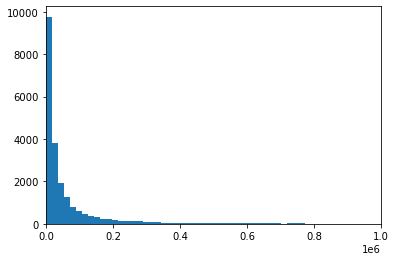

In [41]:
x = residus_per_variable_df["residuals"]
hist, bins, _ = plt.hist(x, bins=10000)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.hist(x, bins=logbins)
# plt.xscale('log')
plt.xlim(left = -0.5, right=1000000)
plt.title("Repartition des residus moyen par couple NC x Produit")

plt.show()

          residuals
count  2.187600e+04
mean   1.779678e+05
std    2.416045e+06
min    0.000000e+00
50%    2.210043e+04
75%    6.569195e+04
80%    8.765297e+04
90%    1.918256e+05
99%    1.812741e+06
99.9%  2.159798e+07
max    1.800326e+08


C:\Users\DGDDI\AppData\Local\Temp/ipykernel_18236/3860244622.py:13: RuntimeWarning: divide by zero encountered in log10
  logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
C:\Users\DGDDI\anaconda3\lib\site-packages\numpy\core\function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\DGDDI\anaconda3\lib\site-packages\numpy\core\function_base.py:163: RuntimeWarning: invalid value encountered in add
  y += start
C:\Users\DGDDI\anaconda3\lib\site-packages\numpy\lib\histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


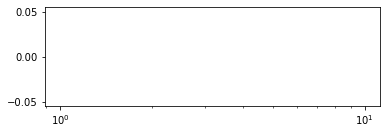

                               columns     residuals
11214                   Inde8708803590  32998.112595
15947  Russie, Fédération de8803300099  32988.574166
15563            Royaume-Uni8442500000  32985.783784
18433                Tunisie6107110000  32977.082981
2814                   Chine7317006090  32972.316749
13741                Maurice9603301000  32971.543180
13506                  Maroc7419999099  32960.837416
7988                  France0406909300  32960.798142
13281                  Maroc3301909000  32957.918736
16236              Singapour8548909099  32955.986856


In [14]:
# 1 - Residus per SH analysis
# Adding labels
import matplotlib.pyplot as plt
cols = pd.Series(final.columns, name='columns')
residus_per_variable = pd.Series(residus_per_variable, name='residuals')
residus_per_variable_df = pd.concat([cols, residus_per_variable], axis=1)

print(residus_per_variable_df.describe(percentiles = [0.5,0.75,0.8,0.9,0.99,0.999]))
# Stats descs
# Distribution of residuals per countries x NC (in €)
x = residus_per_variable_df["residuals"]
hist, bins, _ = plt.hist(x, bins=100)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show()

# TOP 0.001 % of NC (outliers ?)
quantile = residus_per_variable_df.residuals.quantile(0.6)
print(residus_per_variable_df[residus_per_variable_df.residuals <
                        quantile].sort_values("residuals", ascending=False)[0:10])

col_list = residus_per_variable_df[residus_per_variable_df.residuals <
                        quantile].sort_values("residuals", ascending=False)[0:10]["columns"]

In [78]:
# Analysis  specific serie

def serie_analysis(index_col):

    selected_index = cols[cols == index_col].index[0]
    
    print("train_serie")
    train_serie = list(first_train[:, selected_index])
    print(train_serie)
        
    print("residuals")
    residuals_serie = list(residual_matrix[:, selected_index])
    print(residuals_serie)

    print("pred_serie")
    pred_serie = list(first_pred[:, selected_index])
    print(pred_serie)

    print("test_serie")
    test_serie = list(first_test[:, selected_index])
    print(test_serie)

    # TODO - PLOT NORMAL VS RESIDUALS


    # plot each series
    plt.title(index_col)
    #fig, ax = plt.subplots()
    #ax.axis([-1, 10000, 1, 10000000])
    #ax.loglog()
    plt.plot(residuals_serie, label="predicted")
    plt.plot(test_serie, label="true values")
    plt.legend(loc="upper right")
    plt.yscale("log")
    #plt.legend(handles=[pred_serie, pred_serie])
    plt.show()
    return("DONE")
